## Synthetic data for supernovae compilations

#### In this notebook, we train an ANN with supernovae compitation.  In order to deal with the covariance matrix, we test two differents ways:

1) Add the statistical errors at the covariance matrix $\Sigma$ of the systematic errors of JLA and Pantheon supernovaes compilation. Then, we use the fact that $\Sigma$ is symmetrical and we can to use the spectral theorem: $\Sigma = P D P^T$

  and we add $D$ to the dataset to train a neural network as a feature instead the statistical error. 
  When we make predictions, we need to take a subspace of the original eigenvector matrix P and obtain a new covariance matrix.
  
 2) We don't use any properties of the matrix, only train ANN with z, $D_L$ and the statistical error. When we make predictions, we take any submatrix of the original covariance matrix.

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers

### Read the JLA covariance matrix

In [2]:
# syscov = np.loadtxt('data/pantheon_errors.txt',skiprows=1).reshape((1048,1048))
syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))

### This matrix have sigly difference in the out diagonal elements, we fix it:

In [3]:
count = 0

for i in range(len(syscov)):
    for j in range(len(syscov)):
        if np.iscomplex(syscov[i,j]):
            print("COMPLEX")
        if syscov[i,j] != syscov[j,i]:
#             print(i,j)
#             print(syscov[i,j], syscov[j,i]) 
            count+=1
            syscov[j,i] = syscov[i, j]

count

181

### Now, load the data (redshift, $D_L$ and statistical errors)

In [4]:
# file = 'data/pantheon.txt'
file = 'data/jla_lcparams.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'] )
staterr = data.values[:,2]

In [5]:
# covfull = np.copy(syscov)
# covfull[np.diag_indices_from(covfull)] += staterr**2
# print(np.shape(syscov), np.shape(covfull))
# mincov = np.min(covfull)
# maxcov = np.max(covfull)
# meancov = np.mean(covfull)

(740, 740) (740, 740)


### Generation of the data to feed the neural network.

#### We need z, $D_L$ and statistical error

In [5]:
X = data[['zcmb']].values
# scalerx = MinMaxScaler(feature_range=(-1,1))
# scalerx.fit(X.reshape(-1,1))
# X = scalerx.transform(X.reshape(-1,1))
# print(data[['mb']].values)

dl = np.reshape(data[['mb']].values, (len(X), 1))
# scalerdl = MinMaxScaler(feature_range=(-1,1))
# scalerdl.fit(dl.reshape(-1,1))
# dl = scalerdl.transform(dl.reshape(-1,1))


# Use err for method 2
err = np.reshape(data[['dmb']].values, (len(X), 1))

# scalereig = MinMaxScaler(feature_range=(-1,1))
# scalereig.fit(eigenval.reshape(-1,1))
# eigenval = scalereig.transform(eigenval.reshape(-1,1))

Y = np.concatenate((dl, err), axis=1)
print(np.shape(X), np.shape(Y))





(740, 1) (740, 2)


### Shuffle data and split in test and trainning set

In [6]:
shuffle = [x for x in range(len(X)) if x%2 ==1]
comp = [x for x in range(len(X)) if x%2 ==0]
shuffle.extend(comp)
split = 0.8

X = X[shuffle]
Y = Y[shuffle]

ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
Y_train, Y_test = np.split(Y, indx)

### Define a model and some hyperparameters:

In [7]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0001,
                                   patience=100,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = tf.keras.initializers.RandomNormal() 

def model(input_x):
    efirst = Dense(300, activation='relu', input_shape=(1,))(input_x)
    ehidden = Dense(100, activation='relu')(efirst)
    ehidden2 = Dense(300, activation='relu')(ehidden)
    elast = Dense(2, activation='linear')(ehidden2)
    return elast

batch_size = 8
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 300)               600       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 300)               30300     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 602       
Total params: 61,602
Trainable params: 61,602
Non-trainable params: 0
_________________________________________________________________


In [8]:
model_train = neural_model.fit(X_train, Y_train, batch_size=batch_size,
                               epochs=epochs, verbose=1,
                               validation_data=(X_test, Y_test),
                               callbacks=callbacks)

Epoch 1/500
74/74 [==============================] - 1s 8ms/step - loss: 96.0035 - val_loss: 9.4635
Epoch 2/500
74/74 [==============================] - 0s 5ms/step - loss: 4.8225 - val_loss: 1.6103
Epoch 3/500
74/74 [==============================] - 0s 4ms/step - loss: 1.6191 - val_loss: 1.0831
Epoch 4/500
74/74 [==============================] - 0s 4ms/step - loss: 0.7867 - val_loss: 1.2991
Epoch 5/500
74/74 [==============================] - 0s 4ms/step - loss: 0.6651 - val_loss: 1.5215
Epoch 6/500
74/74 [==============================] - 0s 4ms/step - loss: 0.6313 - val_loss: 1.6420
Epoch 7/500
74/74 [==============================] - 0s 4ms/step - loss: 0.6327 - val_loss: 1.7053
Epoch 8/500
74/74 [==============================] - 0s 4ms/step - loss: 0.6066 - val_loss: 1.4851
Epoch 9/500
74/74 [==============================] - 0s 4ms/step - loss: 0.6061 - val_loss: 1.4554
Epoch 10/500
74/74 [==============================] - 0s 4ms/step - loss: 0.5839 - val_loss: 1.4864
Epoch 11

Epoch 83/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0914 - val_loss: 0.1367
Epoch 84/500
74/74 [==============================] - 0s 5ms/step - loss: 0.0915 - val_loss: 0.1099
Epoch 85/500
74/74 [==============================] - 0s 5ms/step - loss: 0.1009 - val_loss: 0.1118
Epoch 86/500
74/74 [==============================] - 0s 5ms/step - loss: 0.1116 - val_loss: 0.1696
Epoch 87/500
74/74 [==============================] - 0s 4ms/step - loss: 0.1270 - val_loss: 0.1366
Epoch 88/500
74/74 [==============================] - 0s 4ms/step - loss: 0.1153 - val_loss: 0.1082
Epoch 89/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0814 - val_loss: 0.1103
Epoch 90/500
74/74 [==============================] - 0s 5ms/step - loss: 0.0826 - val_loss: 0.1424
Epoch 91/500
74/74 [==============================] - 0s 5ms/step - loss: 0.0904 - val_loss: 0.1259
Epoch 92/500
74/74 [==============================] - 0s 5ms/step - loss: 0.0814 - val_loss: 0.1096


74/74 [==============================] - 0s 4ms/step - loss: 0.0748 - val_loss: 0.0862
Epoch 165/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0697 - val_loss: 0.0860
Epoch 166/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0684 - val_loss: 0.0865
Epoch 167/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0756 - val_loss: 0.1121
Epoch 168/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0594 - val_loss: 0.0908
Epoch 169/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0655 - val_loss: 0.0845
Epoch 170/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0679 - val_loss: 0.0929
Epoch 171/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0623 - val_loss: 0.1008
Epoch 172/500
74/74 [==============================] - 0s 4ms/step - loss: 0.1186 - val_loss: 0.2319
Epoch 173/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0999 - val_loss: 0.1133
Epoc

74/74 [==============================] - 1s 12ms/step - loss: 0.0795 - val_loss: 0.0826
Epoch 246/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0677 - val_loss: 0.0970
Epoch 247/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0623 - val_loss: 0.0759
Epoch 248/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0787 - val_loss: 0.0838
Epoch 249/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0706 - val_loss: 0.0794
Epoch 250/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0604 - val_loss: 0.0908
Epoch 251/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0652 - val_loss: 0.0803
Epoch 252/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0673 - val_loss: 0.0790
Epoch 253/500
74/74 [==============================] - 0s 4ms/step - loss: 0.1075 - val_loss: 0.0782
Epoch 254/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0707 - val_loss: 0.0758
Epo

74/74 [==============================] - 0s 3ms/step - loss: 0.0674 - val_loss: 0.2203
Epoch 327/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0991 - val_loss: 0.0755
Epoch 328/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0696 - val_loss: 0.0761
Epoch 329/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0623 - val_loss: 0.0746
Epoch 330/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0652 - val_loss: 0.0761
Epoch 331/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0608 - val_loss: 0.0748
Epoch 332/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0824 - val_loss: 0.0761
Epoch 333/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0918 - val_loss: 0.0750
Epoch 334/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0690 - val_loss: 0.0783
Epoch 335/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0659 - val_loss: 0.0875
Epoc

74/74 [==============================] - 0s 3ms/step - loss: 0.0635 - val_loss: 0.0973
Epoch 408/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0609 - val_loss: 0.0774
Epoch 409/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0769 - val_loss: 0.0803
Epoch 410/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0647 - val_loss: 0.0734
Epoch 411/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0653 - val_loss: 0.0847
Epoch 412/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0773 - val_loss: 0.0897
Epoch 413/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0713 - val_loss: 0.1122
Epoch 414/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0681 - val_loss: 0.0828
Epoch 415/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0605 - val_loss: 0.0863
Epoch 416/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0773 - val_loss: 0.0746
Epoc

74/74 [==============================] - 0s 4ms/step - loss: 0.0726 - val_loss: 0.0799
Epoch 489/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0652 - val_loss: 0.0832
Epoch 490/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0702 - val_loss: 0.0757
Epoch 491/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0712 - val_loss: 0.0732
Epoch 492/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0738 - val_loss: 0.0777
Epoch 493/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0603 - val_loss: 0.0760
Epoch 494/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0885 - val_loss: 0.1167
Epoch 495/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0642 - val_loss: 0.0747
Epoch 496/500
74/74 [==============================] - 0s 4ms/step - loss: 0.0831 - val_loss: 0.0785
Epoch 497/500
74/74 [==============================] - 0s 3ms/step - loss: 0.0726 - val_loss: 0.0728
Epoc

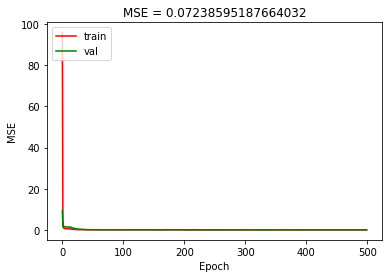

In [12]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('MSE = {}'.format(np.min(model_train.history['val_loss'])))
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_jla_method2.png", dpi=200)

In [13]:
# ranz = np.random.uniform(0, 2, size=100)
ranz = np.linspace(0.001, 2, 100)
pred_random = neural_model.predict(ranz)
# pred_random
np.shape(pred_random[:, 1])

(100,)

### Method 1: We need to choose a submatrix from the original and add the new statistical (fake) errors

In [15]:
subspaceDim = len(ranz)
reduce_cov = syscov[:subspaceDim, :subspaceDim]
reduce_cov += (pred_random[:, 1])**2
print(subspaceDim)

100


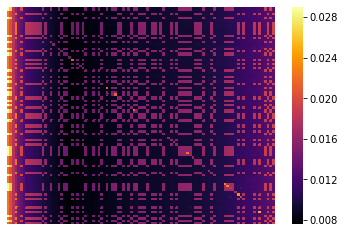

In [16]:
sns.heatmap(pd.DataFrame(reduce_cov), annot=False, fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', robust=False, cbar=True)

plt.savefig("cov_method2.png")

In [17]:
np.savetxt("jlacov_method2_nn.txt", reduce_cov.reshape(100*100), delimiter= " ", header="#100 100")

In [18]:
mookSN = np.concatenate((ranz.reshape(-1,1), pred_random), axis=1)
np.savetxt("jlaDATA_method2_nn.tx", mookSN, delimiter= " ", header="#z dm err")